In [2]:
%reload_ext autoreload
%autoreload 2

import gc
import logging
from functools import partial

# numpy et pandas pour la manipulation du data
import numpy as np
import pandas as pd

import plotly.express as px

from lightgbm import LGBMClassifier

# sklearn preprocessing pour traiter les variables catégorielles
from sklearn.preprocessing import LabelEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.base import ClassifierMixin, is_classifier
from sklearn.dummy import DummyClassifier
from sklearn import preprocessing, model_selection, linear_model, neighbors, metrics, datasets, impute, ensemble
from sklearn.metrics import plot_confusion_matrix, plot_precision_recall_curve, plot_roc_curve, accuracy_score, mean_squared_error, r2_score
from sklearn.linear_model import RidgeClassifier
from lightgbm.sklearn import LGBMRegressor
from sklearn.svm import SVC

from imblearn.over_sampling import SMOTE

from hyperopt import fmin, tpe, hp, anneal, Trials, space_eval

# File system manangement
import os

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# matplotlib et seaborn pour tracer les graphes
import matplotlib.pyplot as plt
import seaborn as sns

#autres librairies
import missingno as msno

# Import des modules contenant les fonctions utilitaires
import src.my_module.data_helpers as dth

In [3]:
data = pd.read_csv('merge2.csv')
dth.displayDataShape("Le jeu de données contient", data)

Le jeu de données contient : 356251 lignes et 798 colonnes



In [4]:
train_data = data[data['TARGET'].notnull()]
test_data = data[data['TARGET'].isnull()]

In [5]:
dth.displayDataShape("Le jeu d'entraînement contient", train_data)

Le jeu d'entraînement contient : 307507 lignes et 798 colonnes



In [6]:
dth.displayDataShape("Le jeu de test contient", test_data)

Le jeu de test contient : 48744 lignes et 798 colonnes



In [7]:
del data
gc.collect()

0

In [8]:
train_data.head()

,index,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,CC_NAME_CONTRACT_STATUS_Signed_MAX,CC_NAME_CONTRACT_STATUS_Signed_MEAN,CC_NAME_CONTRACT_STATUS_Signed_SUM,CC_NAME_CONTRACT_STATUS_Signed_VAR,CC_NAME_CONTRACT_STATUS_nan_MIN,CC_NAME_CONTRACT_STATUS_nan_MAX,CC_NAME_CONTRACT_STATUS_nan_MEAN,CC_NAME_CONTRACT_STATUS_nan_SUM,CC_NAME_CONTRACT_STATUS_nan_VAR,CC_COUNT
0,0,100002,1.0,0,0,0,0,202500.0,406597.5,24700.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,100003,0.0,1,0,1,0,270000.0,1293502.5,35698.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,100004,0.0,0,1,0,0,67500.0,135000.0,6750.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,100006,0.0,1,0,0,0,135000.0,312682.5,29686.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0
4,4,100007,0.0,0,0,0,0,121500.0,513000.0,21865.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
feature_importance = pd.read_csv('feature_importance.csv').sort_values("importance", ascending=False)
feature_importance.head()

,feature,importance,fold
3424,PAYMENT_RATE,3955,5
5014,PAYMENT_RATE,3872,7
32,EXT_SOURCE_3,3868,1
6604,PAYMENT_RATE,3764,9
7187,EXT_SOURCE_3,3753,10


In [10]:
test = feature_importance.groupby('feature').mean().sort_values("importance", ascending=False)
test.describe()

,importance,fold
count,795.00000,795.0
mean,371.15673,5.5
std,549.11526,0.0
min,0.00000,5.5
25%,16.60000,5.5
50%,133.70000,5.5
75%,491.25000,5.5
max,3683.40000,5.5


In [11]:
list_features = test[:100].index
new_train_data = train_data[list_features.insert(0, 'TARGET')]
new_test_data = test_data[list_features]

### Préparation des données

In [12]:
X = new_train_data.drop(['TARGET'], axis=1)
y = new_train_data['TARGET']

In [13]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2)

### Normalisation des données

In [14]:
std_scale = preprocessing.StandardScaler().fit(X_train)
X_train_std = pd.DataFrame(
    std_scale.transform(X_train),
    columns=X_train.columns
)
X_test_std = pd.DataFrame(
    std_scale.transform(X_test),
    columns=X_test.columns
)

In [15]:
X_train_std.describe()

,PAYMENT_RATE,EXT_SOURCE_3,EXT_SOURCE_2,DAYS_BIRTH,EXT_SOURCE_1,DAYS_EMPLOYED,DAYS_EMPLOYED_PERC,DAYS_REGISTRATION,DAYS_ID_PUBLISH,INSTAL_DBD_MEAN,...,PREV_NAME_TYPE_SUITE_Unaccompanied_MEAN,CLOSED_DAYS_CREDIT_MIN,CLOSED_DAYS_CREDIT_ENDDATE_MIN,PREV_AMT_CREDIT_MEAN,PREV_RATE_DOWN_PAYMENT_MEAN,APPROVED_APP_CREDIT_PERC_MIN,TOTALAREA_MODE,INSTAL_PAYMENT_PERC_VAR,INSTAL_AMT_PAYMENT_MAX,PREV_AMT_APPLICATION_MEAN
count,2.459970e+05,1.971880e+05,2.454750e+05,2.460050e+05,1.073500e+05,2.016600e+05,2.016600e+05,2.460050e+05,2.460050e+05,2.332500e+05,...,2.327650e+05,1.840050e+05,1.827660e+05,2.327650e+05,2.188450e+05,2.319680e+05,1.275260e+05,2.326790e+05,2.332420e+05,2.327650e+05
mean,-5.343918e-16,-6.632837e-16,7.441246e-16,-2.071964e-16,3.175083e-16,-2.876527e-17,-7.729775e-17,1.444276e-16,-1.242594e-16,1.253636e-17,...,2.624622e-16,3.572528e-17,6.301931e-17,2.250386e-16,3.879404e-16,-9.588089e-16,-1.008473e-16,-4.456280e-15,-1.441797e-16,-2.181616e-16
std,1.000002e+00,1.000003e+00,1.000002e+00,1.000002e+00,1.000005e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,...,1.000002e+00,1.000003e+00,1.000003e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000004e+00,1.000002e+00,1.000002e+00,1.000002e+00
min,-1.406637e+00,-2.617380e+00,-2.693742e+00,-2.098682e+00,-2.308408e+00,-6.614134e+00,-1.174005e+00,-5.321274e+00,-2.356156e+00,-1.339973e+00,...,-9.576822e-01,-1.314459e+00,-2.556362e+01,-1.025356e+00,-9.138669e-01,-2.376327e+00,-9.541597e-01,-5.974407e-03,-5.569502e-01,-1.003954e+00
25%,-7.465877e-01,-7.173447e-01,-6.372891e-01,-8.367816e-01,-7.968812e-01,-3.353516e-01,-7.541817e-01,-7.076724e-01,-8.649555e-01,-6.107743e-01,...,-9.576822e-01,-9.221286e-01,-5.237086e-01,-6.217426e-01,-9.138669e-01,2.452754e-02,-5.709060e-01,-5.974407e-03,-4.999217e-01,-5.996005e-01
50%,-1.645002e-01,1.277715e-01,2.701488e-01,6.647342e-02,1.809859e-02,3.148534e-01,-2.858007e-01,1.368398e-01,-1.733457e-01,-2.346614e-01,...,-1.154793e-01,-1.601029e-01,-5.145880e-02,-3.166958e-01,-1.740527e-01,2.538560e-01,-3.147849e-01,-5.974407e-03,-4.119332e-01,-3.124133e-01
75%,4.602893e-01,8.063295e-01,7.802571e-01,8.309423e-01,8.187499e-01,6.910861e-01,4.659718e-01,8.442890e-01,8.455202e-01,3.143962e-01,...,7.267236e-01,8.370694e-01,3.981833e-01,2.773098e-01,2.985484e-01,5.315513e-01,2.345764e-01,-5.974378e-03,-2.114258e-02,2.419528e-01
max,3.145928e+00,1.969169e+00,1.782925e+00,1.957721e+00,2.183128e+00,1.017893e+00,4.272947e+00,1.414959e+00,1.983629e+00,3.092706e+01,...,2.411129e+00,2.347289e+00,2.043991e+01,2.343274e+01,1.010363e+01,1.216306e+01,8.325591e+00,3.205682e+02,1.469593e+01,2.544041e+01


In [16]:
#msno.bar(X_train_std)

### Imputation des valeurs manquantes

In [17]:
imputer = impute.IterativeImputer(n_nearest_features=min(5, int(len(X_train_std.columns) / 10))).fit(X_train_std)

X_train_std = pd.DataFrame(
    imputer.transform(X_train_std),
    columns=X_train_std.columns
)

X_test_std = pd.DataFrame(
    imputer.transform(X_test_std),
    columns=X_test_std.columns
)

### Analyse en composantes principales (ACP)

In [18]:
#dth.acpAnalysis(X_res, y_res)

### Modélisation et évaluation des modèles

In [19]:
results = {}

#### Modèle de référence

100%|██████████| 10/10 [00:06<00:00,  1.56trial/s, best loss: 0.014510924574703765]
Temps total du predict : 0.0 secondes:
Meilleurs paramètres : {'strategy': 'most_frequent'}


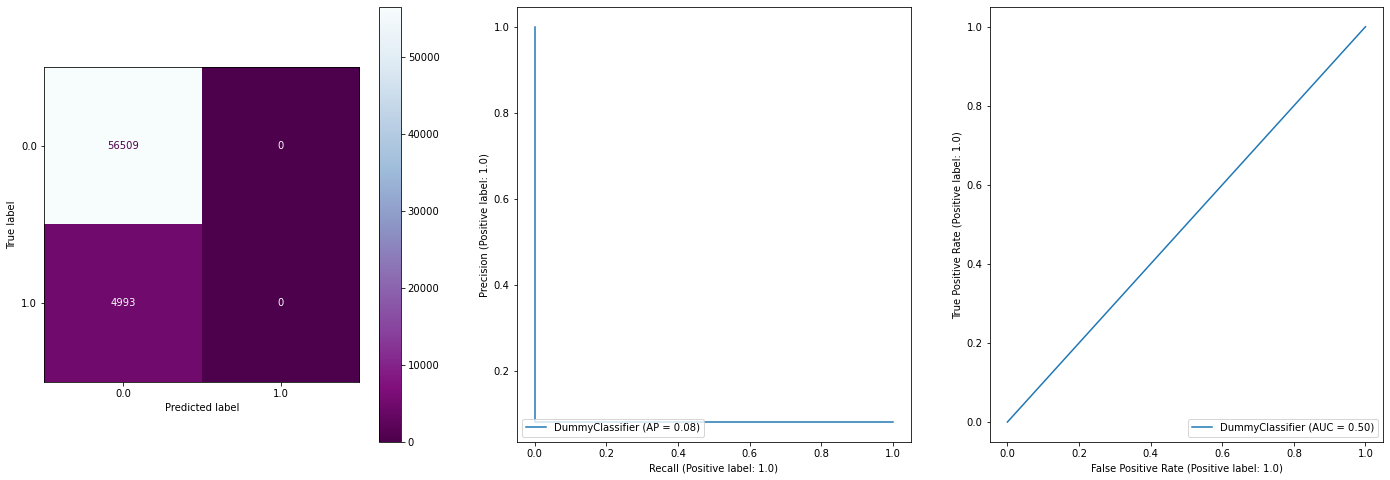

In [20]:
dummy_classifier = DummyClassifier(random_state=42)

space = {
        'strategy': hp.choice('strategy', ['stratified', 'most_frequent', 'prior', 'uniform'])
    }

dummyClassifier_results = dth.find_best_parameters(dummy_classifier, space, X_train_std, y_train, X_test_std, smote=False)

results['dummyClassifier'] = dummyClassifier_results

print(f"Temps total du predict : {dummyClassifier_results['time']} secondes:")
print(f"Meilleurs paramètres : {dummyClassifier_results['best']}")

dth.plot_classifier_results(dummyClassifier_results['classifier'], X_test_std, y_test)

In [21]:
#SANS LE SMOTE

ridgeClassifierModel_noSmote = linear_model.RidgeClassifier(random_state=42)

space = {
        'alpha': hp.loguniform('alpha', -10, 10),
        'fit_intercept': hp.choice('fit_intercept', [True, False]),
        'normalize': hp.choice('normalize', [True, False]),
        'solver': hp.choice('solver', ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga'])
    }

ridgeClassifier_noSmote_results = dth.find_best_parameters(ridgeClassifierModel_noSmote, space, X_train_std, y_train, X_test_std, smote=False)

results['ridgeClassifier_noSmote'] = ridgeClassifier_noSmote_results

print(f"Temps total du predict : {ridgeClassifier_noSmote_results['time']} secondes:")
print(f"Meilleurs paramètres : {ridgeClassifier_noSmote_results['best']}")

dth.plot_classifier_results(ridgeClassifier_noSmote_results['classifier'], X_test_std, y_test)

 30%|███       | 3/10 [01:06<02:32, 21.83s/trial, best loss: 0.01322737342736936] 

100%|██████████| 10/10 [24:20<00:00, 146.04s/trial, best loss: 0.010290603849515256]
Temps total du predict : 0.01562190055847168 secondes:
Meilleurs paramètres : {'alpha': 0.0001704945896847593, 'fit_intercept': True, 'normalize': False, 'solver': 'lsqr'}


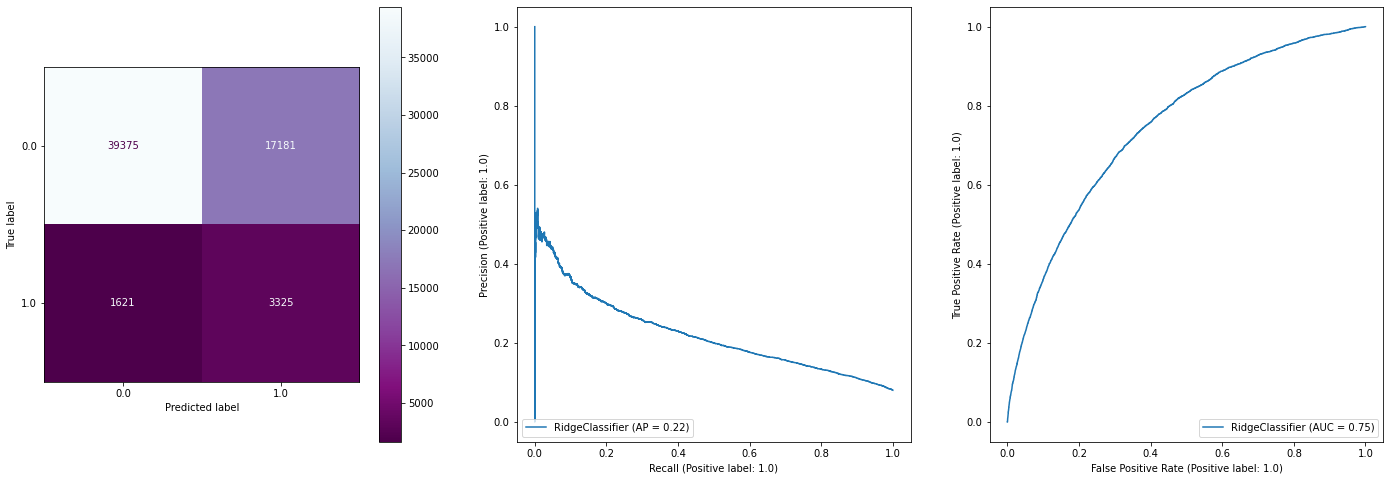

In [ ]:
#AVEC LE SMOTE

ridgeClassifierModel = linear_model.RidgeClassifier(random_state=42)

space = {
        'alpha': hp.loguniform('alpha', -10, 10),
        'fit_intercept': hp.choice('fit_intercept', [True, False]),
        'normalize': hp.choice('normalize', [True, False]),
        'solver': hp.choice('solver', ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga'])
    }

ridgeClassifier_results = dth.find_best_parameters(ridgeClassifierModel, space, X_train_std, y_train, X_test_std, smote=True)

results['ridgeClassifier'] = ridgeClassifier_results

print(f"Temps total du predict : {ridgeClassifier_results['time']} secondes:")
print(f"Meilleurs paramètres : {ridgeClassifier_results['best']}")

dth.plot_classifier_results(ridgeClassifier_results['classifier'], X_test_std, y_test)

In [ ]:
top_coefficients = pd.Series(
        ridgeClassifierModel.coef_[0],
        X_test_std.columns,
    ).map(abs).sort_values(ascending=False).head(20)

fig = px.bar(
            top_coefficients,
            color=top_coefficients.values,
            title="Top 20 variables importance",
            labels={
                "index": "Variable name",
                "value": "Coefficient",
                "color": "Coefficient",
            },
            width=1200,
            height=800,
        )
fig.show()

100%|██████████| 10/10 [1:47:33<00:00, 645.36s/trial, best loss: 0.011459441881262576]
Temps total 0.4600832462310791 secondes:
Best parameters : {'max_depth': 11, 'max_features': 'log2'}


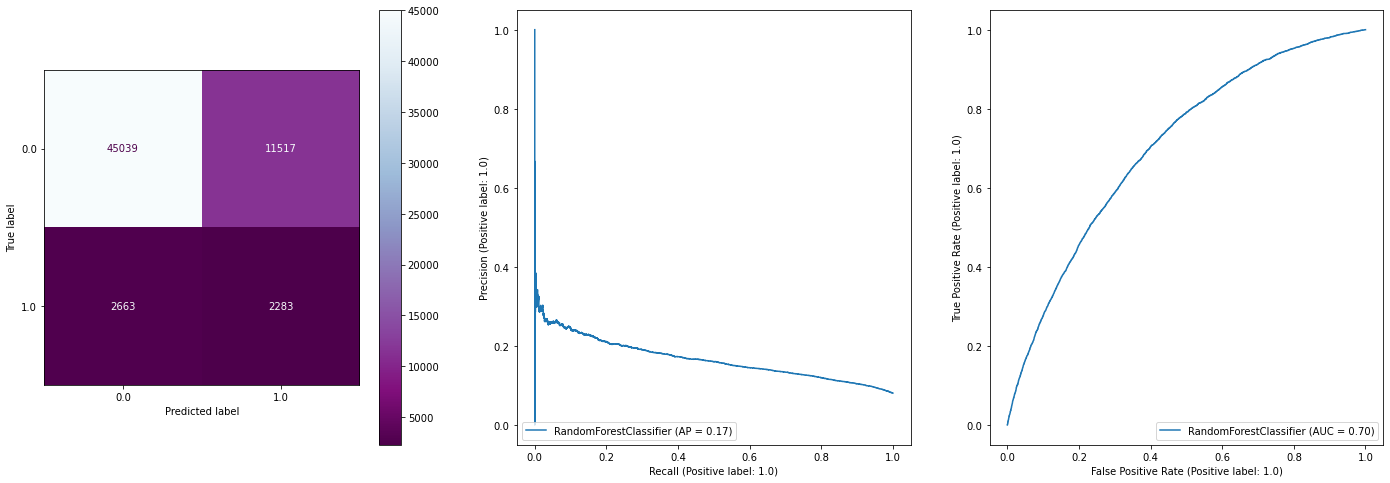

In [ ]:
randomForestModel = ensemble.RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=42)

space = {
        'max_depth': hp.choice('max_depth', [None] + list(range(2, 20, 3))),
        'max_features': hp.choice('max_features', ['auto', 'sqrt', 'log2'])
        }

randomForest_results = dth.find_best_parameters(randomForestModel, space, X_train_std, y_train, X_test_std, smote=True)

results['randomForestClassifier'] = randomForest_results

print(f"Temps total du predict : {randomForest_results['time']} secondes:")
print(f"Meilleurs paramètres : {randomForest_results['best']}")

dth.plot_classifier_results(randomForest_results['classifier'], X_test_std, y_test)

100%|██████████| 10/10 [12:23<00:00, 74.35s/trial, best loss: 0.013515416353326154]
Temps total 0.2309894561767578 secondes:
Best parameters : {'max_depth': 6}


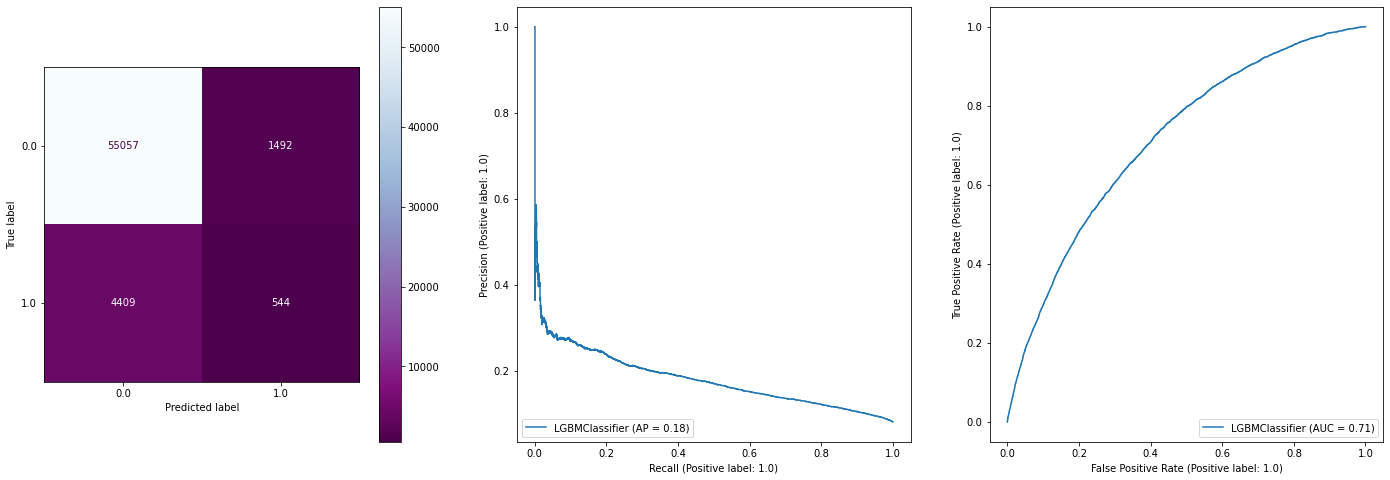

In [ ]:
lgbmModel = LGBMClassifier(n_jobs=-1, random_state=42, objective='binary')

space = {
        'max_depth': hp.choice('max_depth', [None] + list(range(0, 22, 3)))
        }

lgbmClassifier_results = dth.find_best_parameters(lgbmModel, space, X_train_std, y_train, X_test_std, smote=True)

results['lgbmClassifier'] = lgbmClassifier_results

print(f"Temps total {lgbmClassifier_results['time']} secondes:")
print(f"Best parameters : {lgbmClassifier_results['best']}")

dth.plot_classifier_results(lgbmClassifier_results['classifier'], X_test_std, y_test)

In [ ]:
svcModel = SVC(random_state=42)

space = {
        'gamma': hp.choice('gamma', ['scale', 'auto']),
        'kernel': hp.choice('kernel', ['linear', 'poly', 'rbf'])
        }

svc_results = dth.find_best_parameters(svcModel, space, X_train_std, y_train, X_test_std, smote=True)

results['svcClassifier'] = svc_results

print(f"Temps total du predict : {svc_results['time']} secondes:")
print(f"Meilleurs paramètres : {svc_results['best']}")

dth.plot_classifier_results(svc_results['classifier'], X_test_std, y_test)

NameError: name 'SVC' is not defined